# FBN Generator Validation

**Description**

An algorithm for generating fractional Brownian noise (FBN) with a given Hurst exponent.

In [1]:
import numpy as np
import math
import scipy.stats as stats
from tqdm import tqdm
from itertools import islice

from StatTools.analysis.dpcca import dpcca
from StatTools.generators.lbfbm_generator import LBFBmGenerator, normalize

In [2]:
config = {
    "target_len": 4000,
    "overlap_step": 1,
    "hurst_min": 0.1,
    "hurst_max": 2.0,
    "base_min": 1.05,
    "base_max": 2.0,
    "scales": np.array([2**i for i in range(3, 9)]),
}

In [3]:
valdata = {
    "h_list": [i * 0.01 for i in range(int(config["hurst_min"] * 100), 
                                       int(config["hurst_max"] * 100) + 1,
                                       10)],
    "base_list": [i * 0.01 for i in range(int(config["base_min"] * 100), 
                                       int(config["base_max"] * 100) + 1,
                                       5)],
}

In [4]:
def get_test_h(
    base: float,
    filter_len: int,
    h: float,
    scales: np.ndarray,
    step: int,
    target_len: int,
) -> float:
    """
    Calculates the Hurst exponent for the generated trajectory.

    Parameters:
        base: The base of the number system for bins
        filter_len: Filter length
        h: The specified Hurst exponent
        scales: Scales for analysis: points where fluctuation function F(s) is calculated.
        step: The step for analysis (share of scales)

    Returns:
        Calculated Hurst exponent (h_gen)
    """
    generator = LBFBmGenerator(h, filter_len, base)
    trj = []
    for value in islice(generator, target_len):
        trj.append(value)

    signal_z = normalize(np.array(trj[::-1]))
    _, _, f_z, s_z = dpcca(signal_z, 2, step, scales, processes=1, n_integral=0)
    f_z = np.sqrt(f_z)
    f_z /= f_z[0]
    res = stats.linregress(np.log(s_z), np.log(f_z)).slope
    return res

In [5]:
def val_generator(
    H_list: list, base_list: list, scales: np.ndarray, step: float, target_len: int
):
    data = {"base": [], "h": [], "h_test": [], "filter_len": []}
    input_data_map = {}
    for base in base_list:
        input_data_map[base] = int(math.log(target_len, base))
    for base in tqdm(base_list):
        for h in H_list:
            filter_len = input_data_map.get(base, 0)
            h_test = get_test_h(base, filter_len, h, scales, step, target_len)
            data["base"].append(round(base, 2))
            data["h"].append(round(h, 2))
            data["h_test"].append(h_test)
            data["filter_len"].append(filter_len)
    return data

In [6]:
data = val_generator(
    valdata["h_list"], valdata["base_list"], config["scales"], config["overlap_step"], config["target_len"]
)

100%|██████████| 20/20 [01:06<00:00,  3.33s/it]


## Plot results

To validate the different bases of the filter optimization algorithm, we will build a heatmap for the received data. Where the specified h is located on the y-axis, and the x-axis is the base specified when creating the generator. In the center is the error modulus value between the expected h and the one obtained from the generated trajectory.

For clarity, the dimensions of the optimized filter are plotted under the heatmap (note that the filter before optimization = the length of the desired trajectory, that is, 4000 in this case).

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
df = pd.DataFrame(data)
df["error"] = (df["h_test"] - df["h"]).abs()
pivot_table = df.pivot_table(index="h", columns="base", values="error", aggfunc="mean")

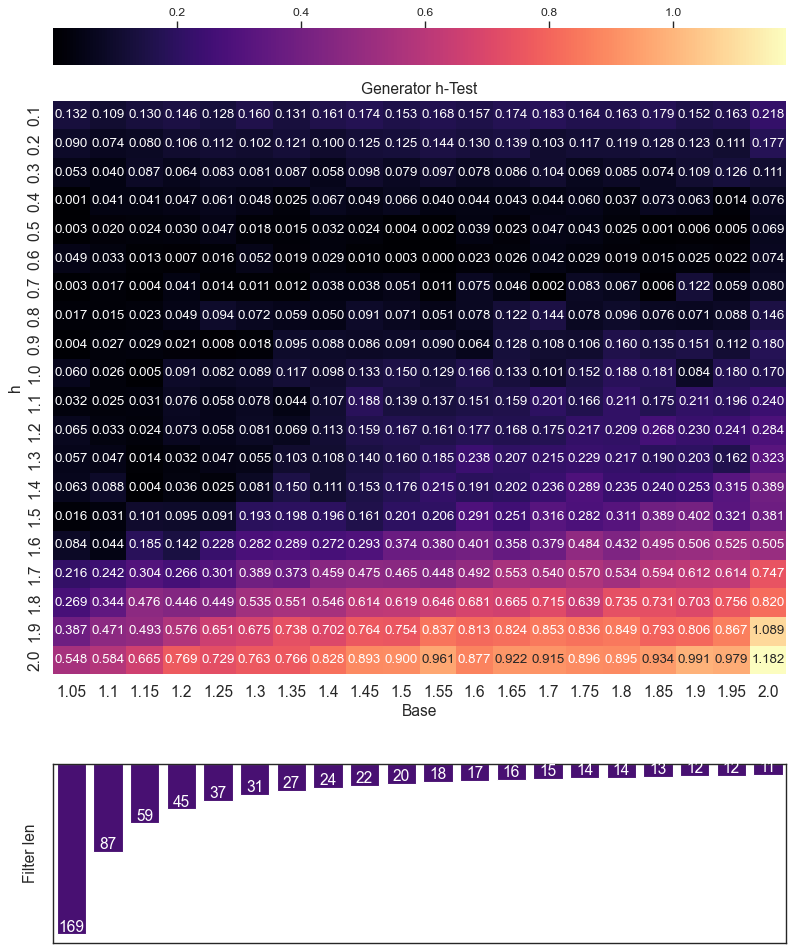

In [9]:
fontsize = 14
sns.set_theme(style="white")
fig = plt.figure(figsize=(16, 16), dpi=80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], yticklabels=[])

sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".3f",
    cmap="magma",
    ax=ax_main,
    cbar_kws=dict(use_gridspec=False, location="top"),
)
ax_bottom.set(title="", ylabel="Filter len", xlabel="")
sns.barplot(data=data, x="base", y="filter_len", ax=ax_bottom, color="indigo")
ax_bottom.bar_label(ax_bottom.containers[0], fontsize=fontsize, color="white")
ax_bottom.set_xticklabels([])
ax_bottom.set_xlabel("")
ax_bottom.invert_yaxis()

ax_main.set(title="Generator h-Test", ylabel="h", xlabel="Base")
ax_main.title.set_fontsize(fontsize)
for item in (
    [ax_main.xaxis.label, ax_main.yaxis.label]
    + ax_main.get_xticklabels()
    + ax_main.get_yticklabels()
):
    item.set_fontsize(fontsize)
for item in (
    [ax_bottom.xaxis.label, ax_bottom.yaxis.label]
    + ax_bottom.get_xticklabels()
    + ax_bottom.get_yticklabels()
):
    item.set_fontsize(fontsize)
plt.show()

MSE and MAE graphs are also constructed to determine valid bases.

In [10]:
results = (
    df.groupby("base")
    .apply(
        lambda x: pd.Series(
            {
                "MSE": mean_squared_error(x["h"], x["h_test"]),
                "MAE": mean_absolute_error(x["h"], x["h_test"]),
            }
        ),
        include_groups=False,
    )
    .reset_index()
)

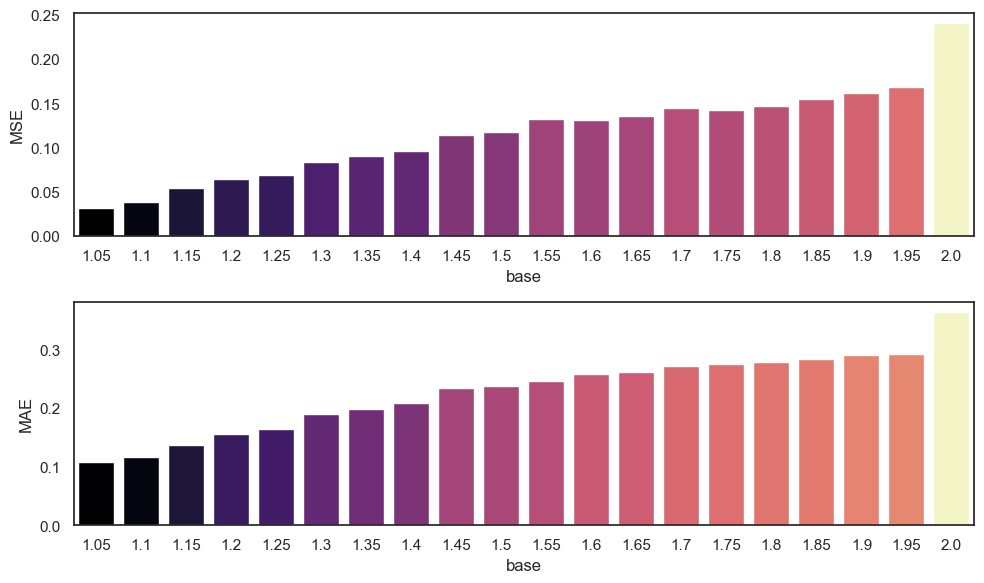

In [11]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
sns.barplot(x="base", y="MSE", hue="MSE", legend=False, data=results, palette="magma")
plt.xlabel("base")
plt.ylabel("MSE")

plt.subplot(2, 1, 2)
sns.barplot(x="base", y="MAE", hue="MAE", legend=False, data=results, palette="magma")
plt.xlabel("base")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()